### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helpFunctions as help
import helpFunctionsRL as helpRL
from operator import index

## Initializing Variables

In [2]:
N = 3
B = 10
alpha = 0.85
beta = 1
p_exp_zero = 0.999
episodes = 10**4
Sum_Rmin_list = [4,8,12,16,20]

## Equal Paritioning

In [3]:
sr_srmin_ep = []
for Sum_Rmin in Sum_Rmin_list:
    sr = []
    for epi in range(0,episodes):
        queue = help.generate_queue(Sum_Rmin,N)
        queue = help.equal_rate_scheduler(queue,N,B)
        sr.append(sum(queue[:,3])/N)
    sr_ep = sum(sr)/episodes
    sr_srmin_ep.append(sr_ep)

## Random Scheduling

In [4]:
sr_srmin_rand = []
for Sum_Rmin in Sum_Rmin_list:
    sr = []
    for epi in range(0,episodes):
        queue = help.generate_queue(Sum_Rmin,N)
        queue = help.random_rate_scheduler(queue,N,B)
        sr.append(sum(queue[:,3])/N)     
    sr_random = sum(sr)/episodes
    sr_srmin_rand.append(sr_random)

## Earliest Deadline First

In [5]:
sr_srmin_edf = []
for Sum_Rmin in Sum_Rmin_list:
    sr = []
    for epi in range(0,episodes):
        queue = help.generate_queue(Sum_Rmin,N)
        queue = help.edf_rate_scheduler(queue,N,B)
        sr.append(sum(queue[:,3])/N)
    sr_edf = sum(sr)/episodes
    sr_srmin_edf.append(sr_edf)

## RL Method

In [6]:
sr_rl_min = []

for m in Sum_Rmin_list:

    sr = []
    p_exp = [0 for i in range(0,episodes)]
    p_exp[0] = p_exp_zero
    
    allPossibleStates = helpRL.everyState(N,m)
    allPossibleActions = helpRL.everyAction(B,N)
    qTable = np.zeros([len(allPossibleStates),len(allPossibleActions)])


    for i in range(0,episodes):
        actions = list(helpRL.allStates(B,N))
        queue = help.generate_queue(m,N)
        currentState = queue[:,0]

        allNegative = helpRL.checkIfAllNegative(currentState)
        time = 0
        p_exp[i] = max(p_exp[i-1]**i,0.01)
        M = N

        while allNegative:
            #currentActionIndex = random.randint(0,len(actions)-1)
            currentActionIndex = helpRL.actionByAgent(qTable,p_exp[i],currentState,allPossibleStates,allPossibleActions,actions)

            rewardAction = np.array(actions[currentActionIndex])
            nextState = np.array(currentState) - rewardAction
            nextState = tuple([int(elem) for elem in nextState])

            [oneNegative,negativeIndices] = helpRL.checkIfOneNegative(nextState)
            if oneNegative:
                [nextState,queue] = helpRL.deleteElement(queue,nextState,negativeIndices,time)
                M = M-len(negativeIndices) 
                if M==0:
                    break
                actions = list(helpRL.allStates(B,M))
            
            allNegative = helpRL.checkIfAllNegative(nextState)
            if allNegative:
                update = helpRL.reward(currentState, rewardAction)
                xCoord = allPossibleStates.index(tuple(nextState))
                qTable[xCoord, currentActionIndex] +=  beta*update

            currentState = nextState

            time = time+1
        
        sr.append(sum(queue[:,3])/N)
    sr_rl = sum(sr)/episodes
    sr_rl_min.append(sr_rl)


## Plot

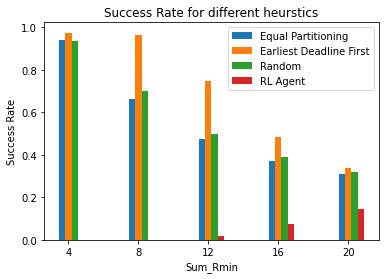

In [7]:
width=0.35

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(np.array(Sum_Rmin_list), sr_srmin_ep,width)
rects2 = ax.bar(np.array(Sum_Rmin_list)+width, sr_srmin_edf, width)
rects3 = ax.bar(np.array(Sum_Rmin_list)+2*width, sr_srmin_rand, width)
rects4 = ax.bar(np.array(Sum_Rmin_list)+3*width, sr_rl_min, width)

ax.set_ylabel('Success Rate')
ax.set_title('Success Rate for different heurstics')
ax.set_xlabel('Sum_Rmin')
ax.set_xticks(np.array(Sum_Rmin_list)+width)
ax.set_xticklabels( ('4', '8', '12', '16', '20') )

#ax.legend( (rects1[0], rects2[0],rects3[0]), ('Equal Partitioning', 'Earliest Deadline First','Random') )
ax.legend( (rects1[0], rects2[0],rects3[0],rects4[0]), ('Equal Partitioning', 'Earliest Deadline First','Random','RL Agent') )

plt.show()